<a href="https://colab.research.google.com/github/Kunaltembhare003/NYC-taxi-trip-time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

#Data preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install geopandas

     |████████████████████████████████| 994 kB 5.4 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 
     |████████████████████████████████| 6.3 MB 64.0 MB/s 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn import preprocessing

In [4]:
#load NYC Taxi trip time dataset
data = pd.read_csv('/content/drive/MyDrive/alma_better/capstone_project/NYC_Taxi_trip_project/NYC_Taxi_Data.csv',sep=',')
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


no null value in dataset

In [6]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [7]:
data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))) # to change scientific value to count value

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06
mean,1.53495,1.66453,-73.9735,40.7509,-73.9734,40.7518,959.492
std,0.498777,1.31424,0.0709019,0.0328812,0.0706433,0.0358906,5237.43
min,1,0,-121.933,34.3597,-121.933,32.1811,1
25%,1,1,-73.9919,40.7373,-73.9913,40.7359,397
50%,2,1,-73.9817,40.7541,-73.9798,40.7545,662
75%,2,2,-73.9673,40.7684,-73.963,40.7698,1075
max,2,9,-61.3355,51.8811,-61.3355,43.921,3.52628e+06


Finding Distance by using pickup_lat,pickup_long,dropoff_lat,dropoff_long values

In [8]:
from geopy.distance import great_circle

In [9]:
def find_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start=(pickup_lat,pickup_long)
 end=(dropoff_lat,dropoff_long)
 
 return great_circle(start,end).km

In [10]:
#finding distance travel in each trip
data['distance'] = data.apply(lambda x: find_distance(x['pickup_latitude'],
                                                      x['pickup_longitude'],
                                                      x['dropoff_latitude'],
                                                      x['dropoff_longitude'] ), axis=1)

#feature creation

AVG SPEED OF VEHICLE

In [11]:
data['avg_speed'] = (data.distance/(data.trip_duration/3600))

In [12]:
data['pickup_weekday']=data['pickup_datetime'].dt.day_name()
data['dropoff_weekday']=data['dropoff_datetime'].dt.day_name()
data['pickup_weekday_num']=data['pickup_datetime'].dt.weekday
data['pickup_hour']=data['pickup_datetime'].dt.hour
data['month']=data['pickup_datetime'].dt.month

divided time zone into four main catogory <br>


*   Morning (6AM to 12PM)
*   Afternoon (12 PM to 4 PM)
*   Evening (4PM to 10 PM)
*   Late night (10PM to 6AM)





In [13]:
# at which time customer board taxi 
def time_of_day(x):
    if x in range(6,12):
        return 'Morning'
    elif x in range(12,16):
        return 'Afternoon'
    elif x in range(16,22):
        return 'Evening'
    else:
        return 'Late night'

In [14]:
data['pickup_timeofday']=data['pickup_hour'].apply(time_of_day)

In [15]:
data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance,avg_speed,pickup_weekday_num,pickup_hour,month
count,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06,1.45864e+06
mean,1.53495,1.66453,-73.9735,40.7509,-73.9734,40.7518,959.492,3.44087,14.4232,3.05037,13.6065,3.51682
std,0.498777,1.31424,0.0709019,0.0328812,0.0706433,0.0358906,5237.43,4.29654,14.9775,1.95404,6.39969,1.68104
min,1,0,-121.933,34.3597,-121.933,32.1811,1,0,0,0,0,1
25%,1,1,-73.9919,40.7373,-73.9913,40.7359,397,1.23184,9.12129,1,9,2
50%,2,1,-73.9817,40.7541,-73.9798,40.7545,662,2.09372,12.792,3,14,4
75%,2,2,-73.9673,40.7684,-73.963,40.7698,1075,3.87534,17.8449,5,19,5
max,2,9,-61.3355,51.8811,-61.3355,43.921,3.52628e+06,1240.91,9274.85,6,23,6


In [16]:
data.shape

(1458644, 19)

In [17]:
data.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance', 'avg_speed', 'pickup_weekday',
       'dropoff_weekday', 'pickup_weekday_num', 'pickup_hour', 'month',
       'pickup_timeofday'],
      dtype='object')

# Univariate Analysis

In [18]:
plt.rcParams["figure.figsize"] = [10,6]

In [19]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,avg_speed,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,month,pickup_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498523,11.856445,Monday,Monday,0,17,3,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805510,9.803673,Sunday,Sunday,6,0,6,Late night
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385108,10.822216,Tuesday,Tuesday,1,11,1,Morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485501,12.465739,Wednesday,Wednesday,2,19,4,Evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188590,9.836608,Saturday,Saturday,5,13,3,Afternoon


##Column 1 and 2: column 'id' and 'vendor_id' <br>
There are only two vendor who provided service

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


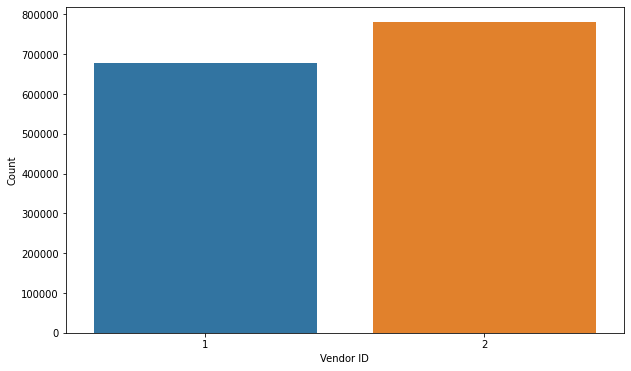

In [20]:
sns.countplot(data.vendor_id)
plt.xlabel('Vendor ID')
plt.ylabel('Count')
plt.show()

## **column 3 and column 4**: from'pickup_datetime' and 'dropoff_datetime' column we created new feature column like '**pickup_weekday**', '**dropoff_weekday**' '**pickup_weekday_num**', '**pickup_hour 	month**', and '**pickup_timeofday**'.

##**column 5: Passenger_count** <br>
from the graph, we can see that there are few trips with passenger broad a taxi is too low. it may be outliers so going to reomve entries with 0, 7, 8, 9 passenger per trip.


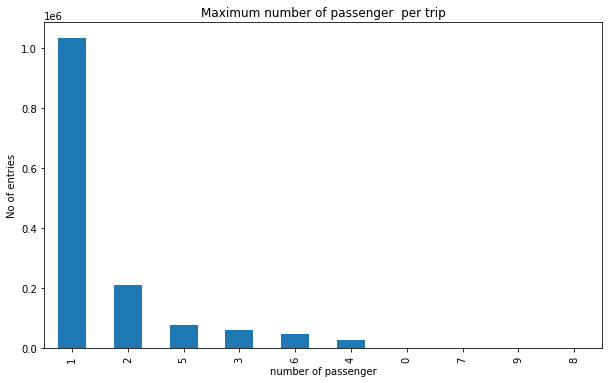

In [21]:
data.passenger_count.value_counts().plot(kind="bar")
plt.xlabel("number of passenger")
plt.ylabel("No of entries")
plt.title("Maximum number of passenger  per trip")
plt.show()



## column 6: pickup_latitude 	pickup_longitude <br>


In [22]:
import folium
from folium.plugins import HeatMap
from folium import plugins


In [23]:
map_NYC = folium.Map([60,-120],zoom_start=7)

In [24]:
'''station = data[['pickup_longitude','pickup_latitude']]
# convert to (n, 2) nd-array format for heatmap
stationArr = station.values

# plot heatmap
map_NYC.add_child(plugins.HeatMap(stationArr, radius=15))
map_NYC'''

"station = data[['pickup_longitude','pickup_latitude']]\n# convert to (n, 2) nd-array format for heatmap\nstationArr = station.values\n\n# plot heatmap\nmap_NYC.add_child(plugins.HeatMap(stationArr, radius=15))\nmap_NYC"

## column 8 & 9: dropoff_latitude 	dropoff_longitude <br>

In [25]:
map_NYC = folium.Map([40.80902,-73.94190],zoom_start=7)

In [26]:
'''station_drop = data[['dropoff_latitude', 'dropoff_longitude']]
# convert to (n, 2) nd-array format for heatmap
stationArr_drop = station_drop.values

# plot heatmap
map_NYC.add_child(plugins.HeatMap(stationArr_drop, radius=15))
map_NYC'''

"station_drop = data[['dropoff_latitude', 'dropoff_longitude']]\n# convert to (n, 2) nd-array format for heatmap\nstationArr_drop = station_drop.values\n\n# plot heatmap\nmap_NYC.add_child(plugins.HeatMap(stationArr_drop, radius=15))\nmap_NYC"

## column 10: Store and forward flag <br>
only two observation  are included in this feature

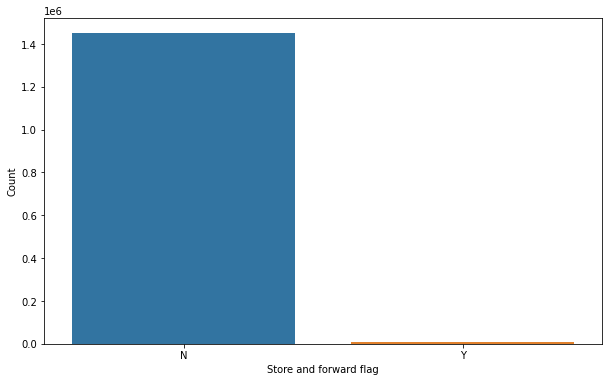

In [27]:
sns.countplot(x='store_and_fwd_flag',data=data)
plt.ylabel('Count')
plt.xlabel('Store and forward flag')
plt.show()

 We can see that only about 0.5% of the trip details were stored in the vehicle memory first

##column 11: trip duration <br>


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


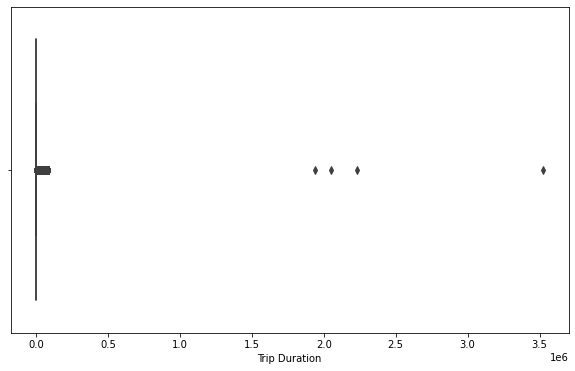

In [28]:
#create boxplot to check probable outliers
sns.boxplot(data.trip_duration)
plt.xlabel('Trip Duration')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


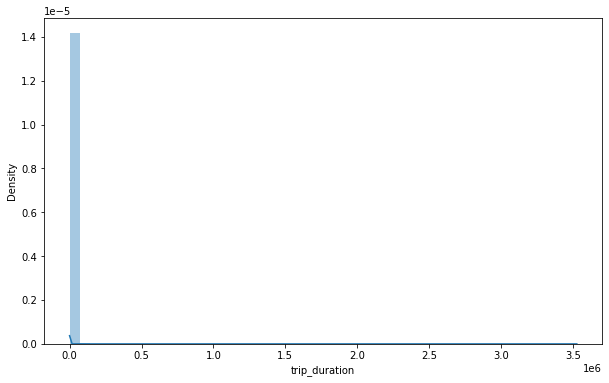

In [29]:
#to check skewness of data 
sns.distplot(data['trip_duration'],norm_hist=True)
plt.show()

In [30]:
print(f" skew coefficient is {data['trip_duration'].skew()}")

 skew coefficient is 343.1639435917362


data is right skewed. using log transformation we can remove skewness.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


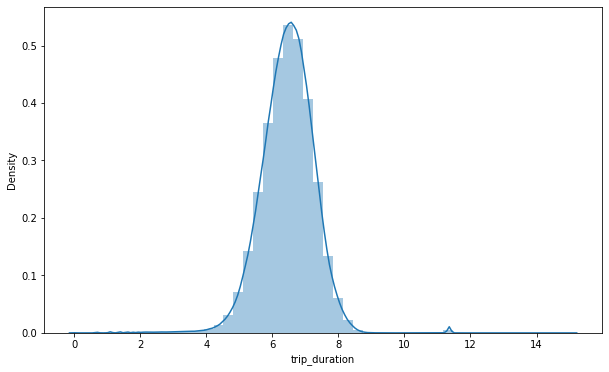

In [31]:
sns.distplot(np.log(data['trip_duration']))
plt.show()

In [32]:
np.log(data['trip_duration'])
data_trip_duration = np.log(data['trip_duration'])
print(f" skew coefficient went from {data['trip_duration'].skew()} to {data_trip_duration.skew()}")

 skew coefficient went from 343.1639435917362 to -0.34070423044801745


## column 12: distance <br>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


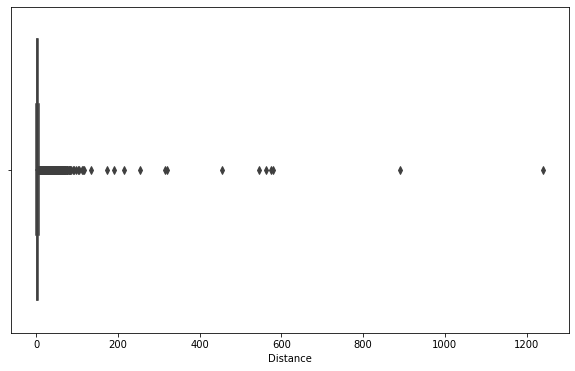

In [33]:
sns.boxplot(data.distance)
plt.xlabel('Distance')
plt.show()

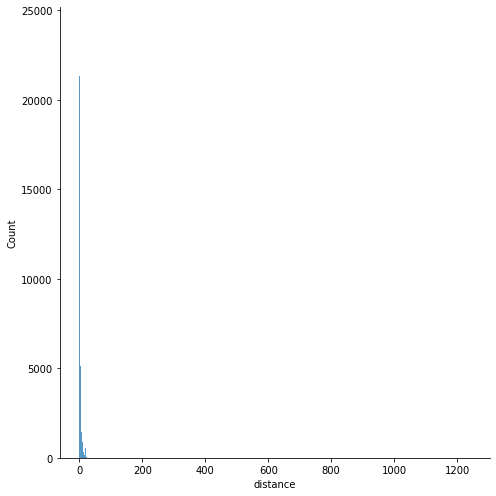

In [34]:

sns.displot(data=data, x='distance', height=7,aspect=1)
plt.show()

In [35]:
print(f"Skew coefficient is {data['distance'].skew()}")

Skew coefficient is 32.63098100465965


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


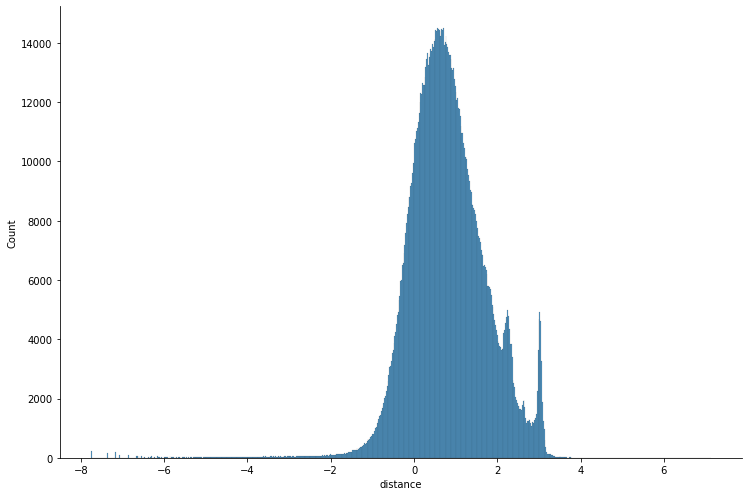

In [36]:
sns.displot(np.log(data["distance"]), height=7,aspect=1.5)
plt.show()

In [37]:
distance_log_skew = np.log(data['distance']).skew()
print(f" Skew coefficient went from {data['distance'].skew()} to {distance_log_skew}")

 Skew coefficient went from 32.63098100465965 to nan


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## column 13: Average speed

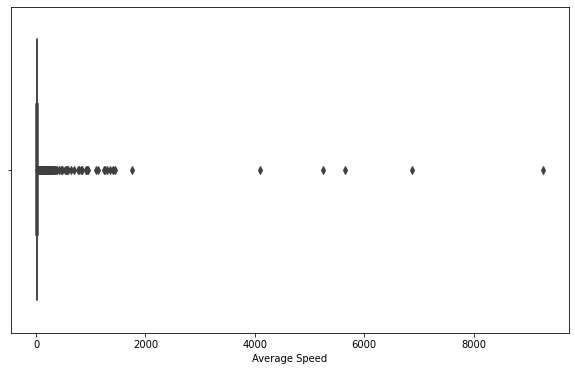

In [38]:
sns.boxplot(x="avg_speed", data=data)
plt.xlabel('Average Speed')
plt.show()

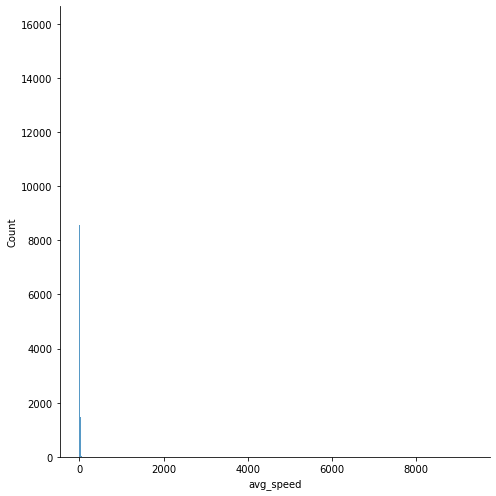

In [39]:

sns.displot(data=data, x='avg_speed', height=7,aspect=1)
plt.show()

In [40]:
print(f"Skew coefficient is {data['avg_speed'].skew()}")

Skew coefficient is 314.1581085599962


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


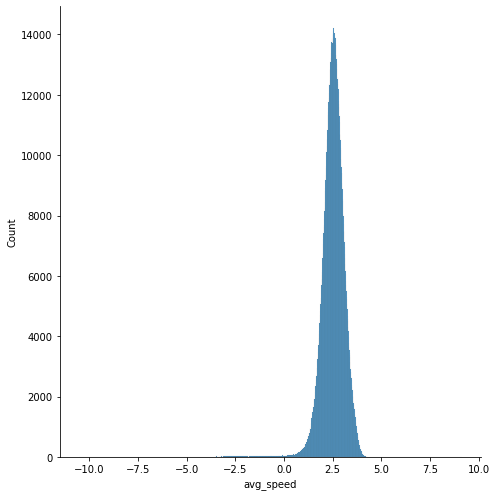

In [41]:
sns.displot(np.log(data["avg_speed"]), height=7,aspect=1)
plt.show()

In [42]:
speed_log_skew = np.log(data["avg_speed"]).skew()
print(f" Skew coefficient went from {data['avg_speed'].skew()} to {speed_log_skew}")

 Skew coefficient went from 314.1581085599962 to nan


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


it's 

## column 14 and 15: pickup_weekday and drop off weekday


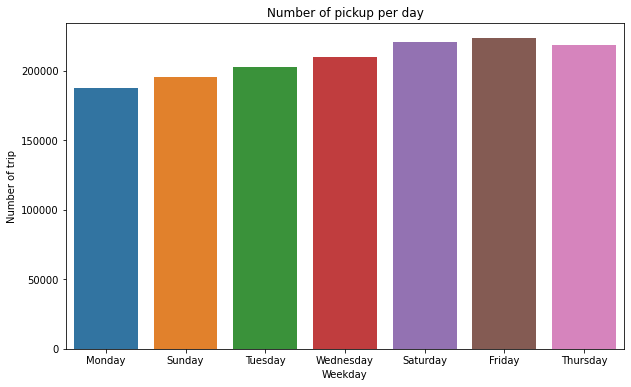

In [43]:
sns.countplot(data=data, x='pickup_weekday')
plt.ylabel('Number of trip')
plt.xlabel('Weekday')
plt.title('Number of pickup per day')
plt.show()

number of trips not much of changed in different days.


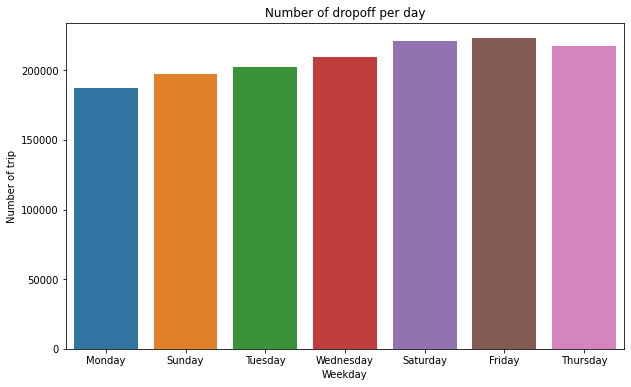

In [44]:
sns.countplot(data=data, x='dropoff_weekday')
plt.ylabel('Number of trip')
plt.xlabel('Weekday')
plt.title('Number of dropoff per day')
plt.show()

## column 16: pick up hour

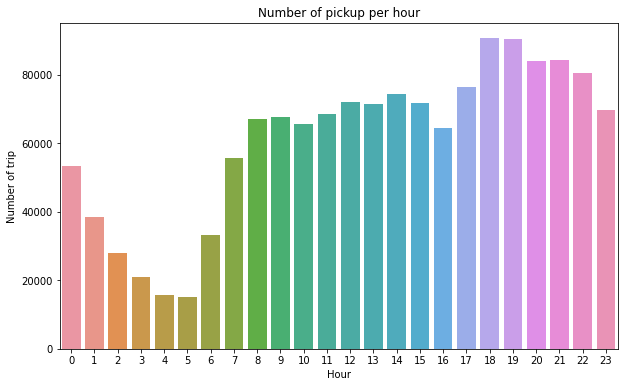

In [45]:
sns.countplot(data=data, x='pickup_hour')
plt.ylabel('Number of trip')
plt.xlabel('Hour')
plt.title('Number of pickup per hour')
plt.show()

most number of taxi booked in evening session.

## column 17: month

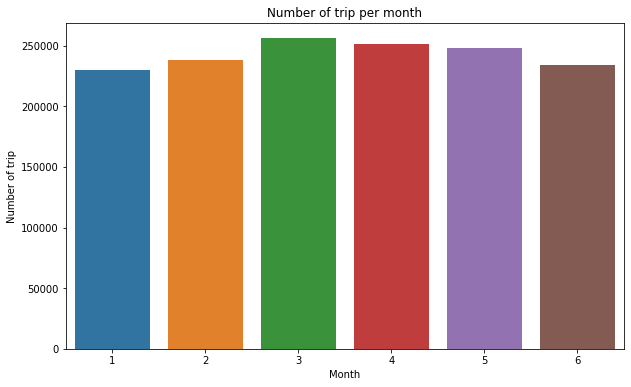

In [46]:
sns.countplot(data=data, x='month')
plt.ylabel('Number of trip')
plt.xlabel('Month')
plt.title('Number of trip per month')
plt.show()

In [47]:
data.month.value_counts()

3    256189
4    251645
5    248487
2    238300
6    234316
1    229707
Name: month, dtype: int64

##column 18: pick up time of day

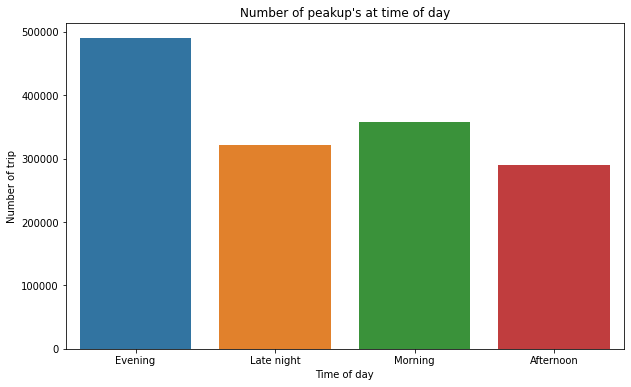

In [48]:
# bar plot for pickup time of a day
sns.countplot(data=data, x="pickup_timeofday")
plt.xlabel("Time of day")
plt.ylabel("Number of trip")
plt.title("Number of peakup's at time of day")
plt.show()


# **feature Enginerring** <br>

## **Data cleaing and wrangling**

In [49]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,avg_speed,pickup_weekday,dropoff_weekday,pickup_weekday_num,pickup_hour,month,pickup_timeofday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,1.498523,11.856445,Monday,Monday,0,17,3,Evening
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,1.805510,9.803673,Sunday,Sunday,6,0,6,Late night
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,6.385108,10.822216,Tuesday,Tuesday,1,11,1,Morning
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1.485501,12.465739,Wednesday,Wednesday,2,19,4,Evening
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1.188590,9.836608,Saturday,Saturday,5,13,3,Afternoon


In [50]:
# remove column  "id" and "vendor_id"
data.drop(["id",'pickup_datetime',"dropoff_datetime", "dropoff_longitude", "dropoff_latitude", "pickup_longitude", "pickup_latitude","pickup_hour"],axis=1,inplace= True)

In [51]:
data.shape

(1458644, 11)

In [52]:
#remove rows with passenger count value =0,7,8,9
df = data.loc[~(data['passenger_count']==0)]
df = df.loc[~(df['passenger_count'] >= 7)]

In [53]:
df.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

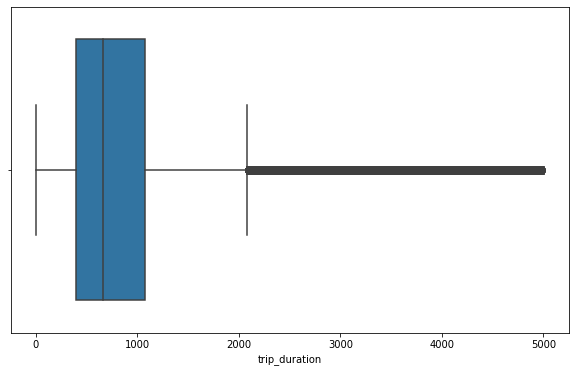

In [54]:
#remove trip duration greater than 5000 second
df = df.loc[~(df['trip_duration'] >= 5000)]
#plot boxplot for filtered data
sns.boxplot(data=df,x='trip_duration')
plt.show()

In [55]:
df.shape

(1454806, 11)

In [56]:
#remove distance above 200 and avg_speed above 50 km/hr (As 2015, maximum speed limit was 48.28 kmph)
df = df.loc[~((df['distance']>=200) | (df["avg_speed"]>=50))]

In [57]:
df.shape

(1451851, 11)

In [58]:
# remove rows if distance travel is zero (maay be it outliers)
df = df[df.distance != 0]

In [59]:
df.shape

(1445968, 11)

In [60]:
#remove 

##log Transfrom <br>
Logarithm transformation (or log transform) is one of the most commonly used mathematical transformations in feature engineering. What are the benefits of log transform:


*   It helps to handle skewed data and after transformation, the distribution becomes more approximate to normal.
*   In most of the cases the magnitude order of the data changes within the range of the data.
*   It also decreases the effect of the outliers, due to the normalization of magnitude differences and the model become more robust.

 


In [61]:
'''df['avg_speed'] = (df['avg_speed']).transform(np.log)
df['distance'] = (df['distance']).transform(np.log)
df['trip_duration'] = (df['trip_duration']).transform(np.log)'''

"df['avg_speed'] = (df['avg_speed']).transform(np.log)\ndf['distance'] = (df['distance']).transform(np.log)\ndf['trip_duration'] = (df['trip_duration']).transform(np.log)"

In [62]:
df.head()

,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,distance,avg_speed,pickup_weekday,dropoff_weekday,pickup_weekday_num,month,pickup_timeofday
0,2,1,N,455,1.498523,11.856445,Monday,Monday,0,3,Evening
1,1,1,N,663,1.805510,9.803673,Sunday,Sunday,6,6,Late night
2,2,1,N,2124,6.385108,10.822216,Tuesday,Tuesday,1,1,Morning
3,2,1,N,429,1.485501,12.465739,Wednesday,Wednesday,2,4,Evening
4,2,1,N,435,1.188590,9.836608,Saturday,Saturday,5,3,Afternoon


#corelation 

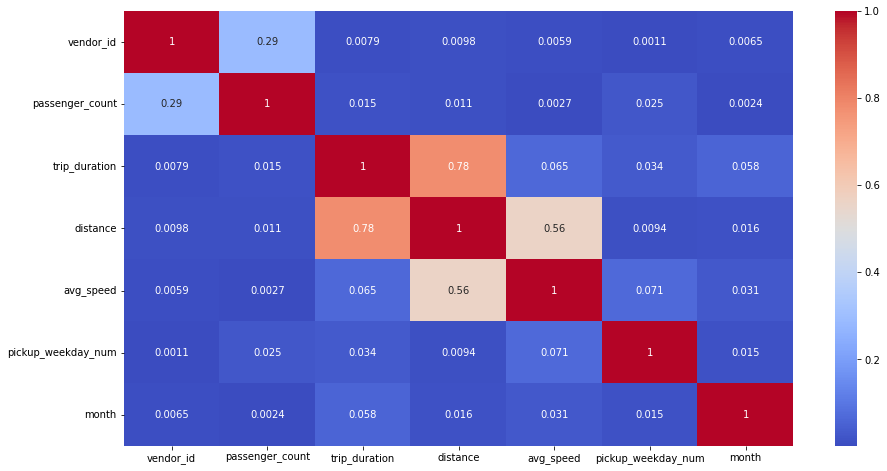

In [63]:
 ## Correlation
plt.figure(figsize=(15,8))
correlation = df.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')
plt.show()

As we can see that,  <br>
"Avg_speed" is 56% corealted with distance. <br>
"trip_duration" is 78% corealted with distance.

In [64]:
#we can also remove "pickup_weekday_num" as "pickup_weekday" and "dropoff_weekday" information also avalibale
df.drop(['pickup_weekday_num'],axis=1,inplace=True)

##check multi collinearity

In [65]:
#Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
#define function to call multicollinearity
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [66]:
df.columns

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration',
       'distance', 'avg_speed', 'pickup_weekday', 'dropoff_weekday', 'month',
       'pickup_timeofday'],
      dtype='object')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1445968 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   vendor_id           1445968 non-null  int64  
 1   passenger_count     1445968 non-null  int64  
 2   store_and_fwd_flag  1445968 non-null  object 
 3   trip_duration       1445968 non-null  int64  
 4   distance            1445968 non-null  float64
 5   avg_speed           1445968 non-null  float64
 6   pickup_weekday      1445968 non-null  object 
 7   dropoff_weekday     1445968 non-null  object 
 8   month               1445968 non-null  int64  
 9   pickup_timeofday    1445968 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 121.4+ MB


In [68]:
calc_vif(df[[i for i in df.describe().columns if i not in ["vendor_id",'passenger_count','store_and_fwd_flag', 'dropoff_weekday', 'pickup_weekday','month','pickup_timeofday']]])

,variables,VIF
0,trip_duration,4.514462
1,distance,5.563332
2,avg_speed,2.614559


we have also remove the Avg_speed feature from the predictor columns as it highhly  corelated with distance.

In [69]:
calc_vif(df[[i for i in df.describe().columns if i not in ['passenger_count','store_and_fwd_flag', 'dropoff_weekday', 'pickup_weekday','month','pickup_timeofday','avg_speed','vendor_id']]])

,variables,VIF
0,trip_duration,4.455897
1,distance,4.455897


##hot encoding

In [70]:
df.columns

Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration',
       'distance', 'avg_speed', 'pickup_weekday', 'dropoff_weekday', 'month',
       'pickup_timeofday'],
      dtype='object')

In [71]:
#drop column "pickup_hour"
#df.drop(['avg_speed'],axis=1,inplace=True)

In [72]:
# One hot encoding
final_data = pd.get_dummies(df, columns=["vendor_id",
                                         "passenger_count",
                                         "store_and_fwd_flag",
                                         "pickup_weekday",
                                         "dropoff_weekday",
                                         "month",
                                         "pickup_timeofday"])

In [73]:
final_data.head()

,trip_duration,distance,avg_speed,vendor_id_1,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_weekday_Friday,pickup_weekday_Monday,pickup_weekday_Saturday,pickup_weekday_Sunday,pickup_weekday_Thursday,pickup_weekday_Tuesday,pickup_weekday_Wednesday,dropoff_weekday_Friday,dropoff_weekday_Monday,dropoff_weekday_Saturday,dropoff_weekday_Sunday,dropoff_weekday_Thursday,dropoff_weekday_Tuesday,dropoff_weekday_Wednesday,month_1,month_2,month_3,month_4,month_5,month_6,pickup_timeofday_Afternoon,pickup_timeofday_Evening,pickup_timeofday_Late night,pickup_timeofday_Morning
0,455,1.498523,11.856445,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,663,1.805510,9.803673,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2124,6.385108,10.822216,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
3,429,1.485501,12.465739,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,435,1.188590,9.836608,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [74]:
final_data.shape

(1445968, 37)

Now we see corelation heatmap between each feature to choose best feature.

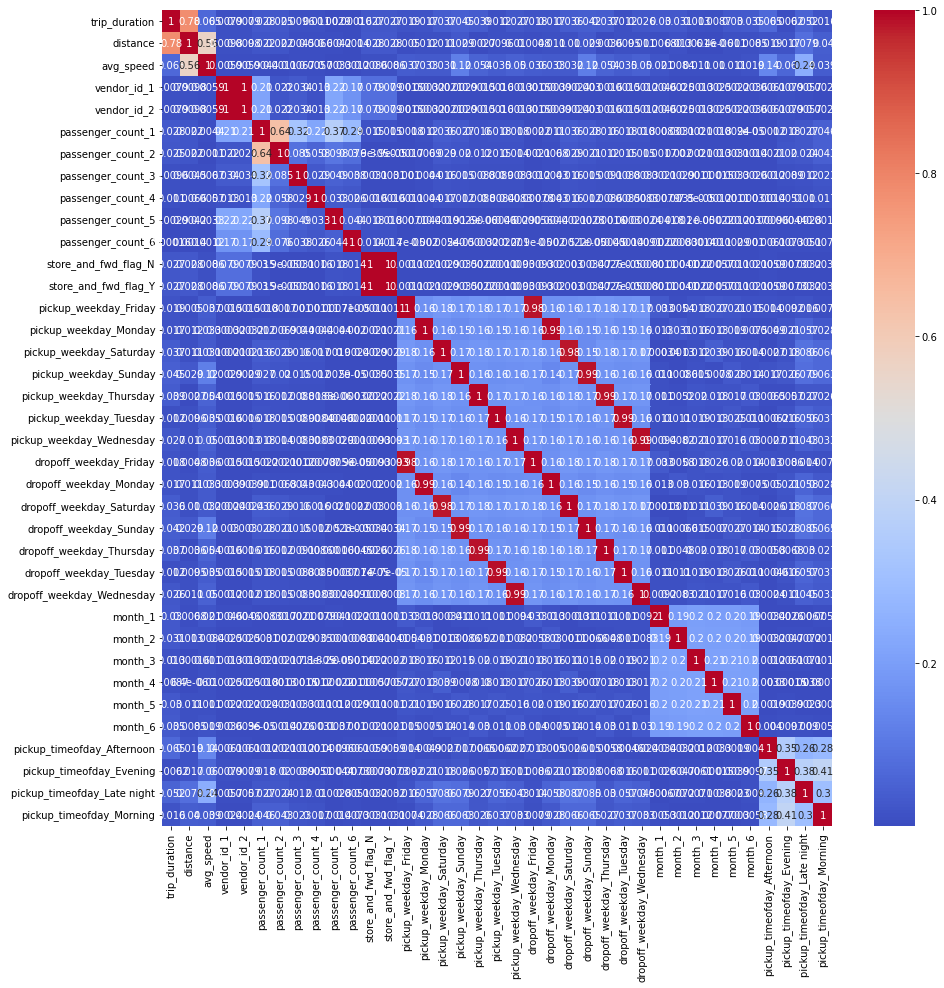

In [75]:
 ## Correlation
plt.figure(figsize=(15,15))
correlation_1 = final_data.corr()
sns.heatmap(abs(correlation_1), annot=True, cmap='coolwarm')
plt.show()

#build model

In [76]:
#importing the libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 

In [77]:
final_data.head()

,trip_duration,distance,avg_speed,vendor_id_1,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_weekday_Friday,pickup_weekday_Monday,pickup_weekday_Saturday,pickup_weekday_Sunday,pickup_weekday_Thursday,pickup_weekday_Tuesday,pickup_weekday_Wednesday,dropoff_weekday_Friday,dropoff_weekday_Monday,dropoff_weekday_Saturday,dropoff_weekday_Sunday,dropoff_weekday_Thursday,dropoff_weekday_Tuesday,dropoff_weekday_Wednesday,month_1,month_2,month_3,month_4,month_5,month_6,pickup_timeofday_Afternoon,pickup_timeofday_Evening,pickup_timeofday_Late night,pickup_timeofday_Morning
0,455,1.498523,11.856445,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,663,1.805510,9.803673,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
2,2124,6.385108,10.822216,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
3,429,1.485501,12.465739,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,435,1.188590,9.836608,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [78]:
final_data.shape

(1445968, 37)

In [79]:
y = final_data['trip_duration']
y.head()

0     455
1     663
2    2124
3     429
4     435
Name: trip_duration, dtype: int64

In [80]:
from scipy.stats import zscore
#select feature
#minmaxscaler
X = final_data.loc[:,final_data.columns != 'trip_duration']

In [81]:
X.head()

,distance,avg_speed,vendor_id_1,vendor_id_2,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_weekday_Friday,pickup_weekday_Monday,pickup_weekday_Saturday,pickup_weekday_Sunday,pickup_weekday_Thursday,pickup_weekday_Tuesday,pickup_weekday_Wednesday,dropoff_weekday_Friday,dropoff_weekday_Monday,dropoff_weekday_Saturday,dropoff_weekday_Sunday,dropoff_weekday_Thursday,dropoff_weekday_Tuesday,dropoff_weekday_Wednesday,month_1,month_2,month_3,month_4,month_5,month_6,pickup_timeofday_Afternoon,pickup_timeofday_Evening,pickup_timeofday_Late night,pickup_timeofday_Morning
0,1.498523,11.856445,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,1.805510,9.803673,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
2,6.385108,10.822216,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
3,1.485501,12.465739,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
4,1.188590,9.836608,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0


In [82]:
X.shape

(1445968, 36)

In [83]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1445968 entries, 0 to 1458643
Data columns (total 36 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   distance                     1445968 non-null  float64
 1   avg_speed                    1445968 non-null  float64
 2   vendor_id_1                  1445968 non-null  uint8  
 3   vendor_id_2                  1445968 non-null  uint8  
 4   passenger_count_1            1445968 non-null  uint8  
 5   passenger_count_2            1445968 non-null  uint8  
 6   passenger_count_3            1445968 non-null  uint8  
 7   passenger_count_4            1445968 non-null  uint8  
 8   passenger_count_5            1445968 non-null  uint8  
 9   passenger_count_6            1445968 non-null  uint8  
 10  store_and_fwd_flag_N         1445968 non-null  uint8  
 11  store_and_fwd_flag_Y         1445968 non-null  uint8  
 12  pickup_weekday_Friday        1445968 non-n

In [84]:
#split train and test data
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.2, random_state = 0) 
print(X_train.shape)
print(X_test.shape)

(1156774, 36)
(289194, 36)


In [85]:
# Transforming data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##implementation of linear regression

In [86]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression().fit(X_train,y_train)

In [87]:
linear_regression.score(X_train,y_train)

0.8084308551775927

In [88]:
linear_regression.coef_

array([ 1.13717313e+04, -2.26224535e+03, -1.89386605e+14, -1.89386605e+14,
        4.14111816e+14,  4.14111816e+14,  4.14111816e+14,  4.14111816e+14,
        4.14111816e+14,  4.14111816e+14,  6.22043768e+13,  6.22043768e+13,
       -5.23208180e+12, -5.23208180e+12, -5.23208180e+12, -5.23208180e+12,
       -5.23208180e+12, -5.23208180e+12, -5.23208180e+12,  1.78057872e+14,
        1.78057872e+14,  1.78057872e+14,  1.78057872e+14,  1.78057872e+14,
        1.78057872e+14,  1.78057872e+14, -5.30992136e+13, -5.30992136e+13,
       -5.30992136e+13, -5.30992136e+13, -5.30992136e+13, -5.30992136e+13,
        6.03695113e+14,  6.03695113e+14,  6.03695113e+14,  6.03695113e+14])

In [89]:
linear_regression.intercept_

-1010351277632441.9

In [90]:
y_pred_train =linear_regression.predict(X_train)

In [91]:
y_pred = linear_regression.predict(X_test)

In [92]:
X_train.shape

(1156774, 36)

In [93]:
d = pd.DataFrame({"actual":y_test,"predicted":y_pred})

d.head()

,actual,predicted
822181,1939,2549.375
523144,271,658.750
807592,721,771.500
386569,2536,1417.625
1291140,247,386.375


In [94]:
from sklearn import metrics
#evalution

print(f'Mean Absolute Error: {metrics.mean_absolute_error(y_test,y_pred)}')
print(f'Mean squared Error: {metrics.mean_squared_error(y_test,y_pred)}')
print(f'Root Mean squared Error: {np.sqrt(metrics.mean_squared_error(y_test,y_pred))}')


Mean Absolute Error: 182.84180601948864
Mean squared Error: 77511.5946905451
Root Mean squared Error: 278.4090420416426


In [96]:
import math
# Train performance
math.sqrt(mean_squared_error(y_train, y_pred_train))

278.5374077412327

In [97]:
# Test performance
math.sqrt(mean_squared_error(y_test, y_pred))

278.4090420416426

In [98]:
r2_score(y_train, y_pred_train)

0.8084308551775927

In [99]:
r2_score(y_test, y_pred)

0.8066401294861597

##implementing Lasso regression

In [100]:
from sklearn.linear_model import Lasso
lasso  = Lasso(alpha=0.01 , max_iter= 3000)

lasso.fit(X_train, y_train)

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=3000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [101]:
lasso.score(X_train, y_train)

0.8084609572603788

In [102]:
lasso.coef_

array([ 1.13674979e+04, -2.26113295e+03, -3.43146389e-01,  1.45253761e-14,
       -4.25086653e+00,  0.00000000e+00,  1.69062354e+00,  3.22387375e+00,
       -2.02423473e+00, -3.18305712e-01, -0.00000000e+00,  0.00000000e+00,
        3.19222747e+01, -6.21329431e+01, -4.27147600e+01, -1.30779791e+02,
        6.53399368e+01, -0.00000000e+00,  4.52193378e+01, -3.00260797e+01,
        3.92028797e+01,  2.59183858e+01,  1.06647762e+02, -5.07601156e+01,
        0.00000000e+00, -3.24193160e+01, -2.25188584e+01, -2.30435283e+01,
       -1.57907506e+01,  3.43220051e-03,  1.30122571e+01,  1.59975390e+01,
        1.48092919e+01, -5.61830321e+00, -7.53361933e+00,  6.69832281e+00])

cross validation

In [103]:
from sklearn.model_selection import GridSearchCV

In [104]:
### Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=3)
lasso_regressor.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29814561597.937603, tolerance: 31152681.694769923
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29991105717.495815, tolerance: 31357282.575907275
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29922244904.979263, tolerance: 31185807.615567885
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298145

GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [105]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.001}

Using  {'alpha': 0.001}  the negative mean squared error is:  -77575.56982905504


In [108]:
y_pred_train_lasso = lasso_regressor.predict(X_train)

In [106]:
y_pred_lasso = lasso_regressor.predict(X_test)

In [109]:
import math
# Train performance
math.sqrt(mean_squared_error(y_train, y_pred_train_lasso))

278.51168350300395

In [111]:
# Test performance
math.sqrt(mean_squared_error(y_test, y_pred_lasso))

278.3820132775339

In [112]:
#train accuracy
r2_score(y_train, y_pred_train_lasso)

0.808466238164733

In [113]:
#test accuracy
r2_score(y_test, y_pred_lasso)

0.8066776715472845

##implementng Ridge regression

In [114]:
from sklearn.linear_model import Ridge

ridge  = Ridge(alpha=0.01)

In [115]:
ridge.fit(X_train,y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [116]:
ridge.score(X_train, y_train)

0.8084662944814118

In [117]:
y_pred_train_ridge = ridge.predict(X_train)

In [118]:
y_pred_ridge = ridge.predict(X_test)

In [119]:
import math
# Train performance
math.sqrt(mean_squared_error(y_train, y_pred_train_ridge))

278.5116425576008

In [120]:
# Test performance
math.sqrt(mean_squared_error(y_test, y_pred_ridge))

278.38190815447604

In [121]:
#train accuracy
r2_score(y_train, y_pred_train_ridge)

0.8084662944814118

In [122]:
#test accuracy
r2_score(y_test, y_pred_ridge)

0.8066778175526261

crossvalidation

In [132]:
##cross validation
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [133]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.01}

Using  {'alpha': 0.01}  the negative mean squared error is:  -77575.59414304334


In [134]:
#Model Prediction
#train 
y_pred_ridge_cv_train = ridge_regressor.predict(X_train)
y_pred_ridge_cv = ridge_regressor.predict(X_test)


In [135]:
import math
# Train performance
math.sqrt(mean_squared_error(y_train, y_pred_ridge_cv_train))

278.5116425576008

In [136]:
# Test performance
math.sqrt(mean_squared_error(y_test, y_pred_ridge_cv))

278.38190815447604

In [137]:
#train accuracy
r2_score(y_train,  y_pred_ridge_cv_train)

0.8084662944814118

In [138]:
#test accuracy
r2_score(y_test, y_pred_ridge_cv)

0.8066778175526261

#desicion tree

In [123]:
from sklearn.tree import DecisionTreeRegressor

In [124]:
dt_reg = DecisionTreeRegressor( max_leaf_nodes=10, random_state=0)
dt_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=10,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [125]:
dt_y_predicted_train = dt_reg.predict(X_train)

In [126]:
#prediction on test set
dt_y_predicted =dt_reg.predict(X_test)

In [139]:
#measure accuracy/ test performance
import math
math.sqrt(mean_squared_error(y_test, dt_y_predicted))

302.2155447151071

In [128]:
# Train performance
math.sqrt(mean_squared_error(y_train, dt_y_predicted_train))

302.18743419611116

In [129]:
# Train performance
r2_score(y_train, dt_y_predicted_train)

0.7745182981585671

In [130]:
#test performance
r2_score(y_test,dt_y_predicted)

0.7721582685277827

cross validation

In [144]:
param_grid = { 'max_depth': [5, 10, 15, None],
              'max_features': ['auto', 'log2']}

dt = DecisionTreeRegressor()
dt_cv = GridSearchCV(estimator = dt, param_grid = param_grid, cv=3, refit=True)
dt_cv.fit(X_train,y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [5, 10, 15, None],
                         'max_features': ['auto', 'log2']},
             pre_dispatch='2*n_jobs', 

In [146]:
print("The best fit alpha value is found out to be :" ,dt_cv.best_params_)
print("\nUsing ",dt_cv.best_params_, " the negative mean squared error is: ", dt_cv.best_score_)

The best fit alpha value is found out to be : {'max_depth': None, 'max_features': 'auto'}

Using  {'max_depth': None, 'max_features': 'auto'}  the negative mean squared error is:  0.9995396890710228


In [147]:
dt_cv_y_pred_train = dt_cv.predict(X_train)


In [149]:
#prediction on test set
dt_cv_y_predicted =dt_reg.predict(X_test)

In [150]:
#measure accuracy/ test performance
import math
math.sqrt(mean_squared_error(y_test, dt_cv_y_predicted))

302.2155447151071

In [151]:
# Train performance
math.sqrt(mean_squared_error(y_train, dt_cv_y_pred_train))

0.0

In [152]:
# Train performance
r2_score(y_train, dt_cv_y_pred_train)

1.0

In [153]:
#test performance
r2_score(y_test,dt_cv_y_predicted)

0.7721582685277827